# High-level model with PyMC3

Here we model the network without getting into low-level details of how the individual components are connected:

Every time we send an order, the network has two states, busy or free. This we model with a probability of bursts parameter. Every time there is a burst, we either end up queuing behind another packet or we don't. This probability of queuing is affected by an abstract "performance" parameter. The same parameter is also used to generate the reaction time distribution - the reaction time is inverse proportional to the performance.

Time to matching engine is then a mixture of distributions representing the cases where we queued (represented by Exponential) or went through without queuing (Normal). The probability of success is determined by the prob. queuing as well as a base success probability, i.e. when we are successful even after getting queued. 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import numpy as np
import scipy.stats as st

%matplotlib inline

# Load data


In [6]:
DATA_DIR = '../data'
df = pd.read_csv(f'{DATA_DIR}/input_data.csv')
df['total_time_to_me'] = df['reaction_time'] + df['time_to_me']

/Users/oyuksel/Workspace/presentations/PyData/London2019/venv/lib/python3.7/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])
/Users/oyuksel/Workspace/presentations/PyData/London2019/venv/lib/python3.7/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


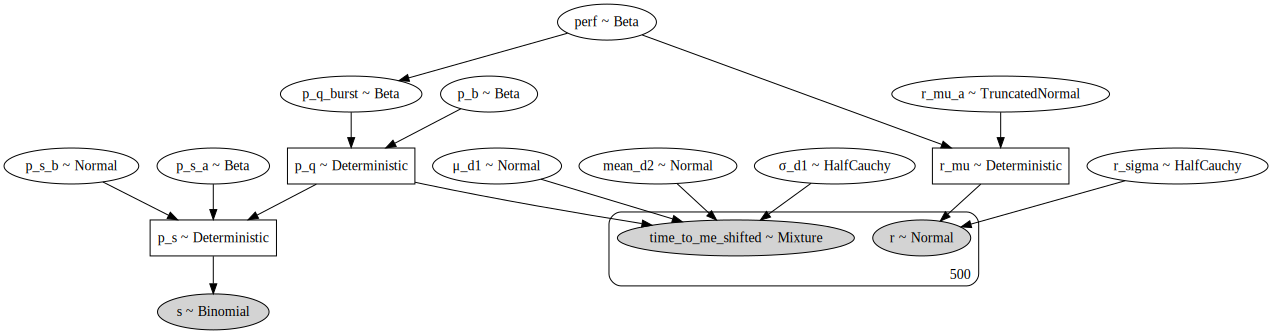

In [7]:
mean_delay = 4440
std_delay = 100

N = 500
success_batches = pm.Minibatch(df.success.values, batch_size=N)
reaction_time = pm.Minibatch(df.reaction_time.values, batch_size=N)

time_to_me_batch = pm.Minibatch(df.time_to_me.values, batch_size=N)
time_to_me_shifted_batch = pm.Minibatch(df.time_to_me.astype(float).values-mean_delay, batch_size=N)

mean_reaction_time = 600
std_reaction_time = 25
best_reaction_time = 100

import theano.tensor as tt
from theano import shared

with pm.Model() as model_delay_hierarchical:     
    # Abstract
    perf = pm.Beta('perf', alpha=.5, beta=.5)

    # Reaction time
    r_mu_a = pm.TruncatedNormal('r_mu_a', mu=best_reaction_time, sigma=25, lower=1)
    r_mu = pm.Deterministic('r_mu', var=r_mu_a/perf)
    r_sigma = pm.HalfCauchy('r_sigma', beta=std_reaction_time)
    reaction_time = pm.Normal('r', mu=r_mu, sigma=r_sigma, observed=reaction_time)
    
    # Bursts and queuing
    p_b = pm.Beta('p_b', alpha=.3, beta=.7) # Probability of burst
    p_q_burst = pm.Beta(name='p_q_burst', alpha=1-perf, beta=perf ) # Probability of queuing when burst
    p_q = pm.Deterministic('p_q', var=p_b * p_q_burst) # Probability of queuing
    

    
    # Time to matching engine
    ## Component parameters
    mu_d1 = pm.Normal(name='μ_d1', mu=0, sigma=10)
    sigma_d1 = pm.HalfCauchy(name='σ_d1', beta=std_delay)
    
    mean_d2 = pm.Normal(name='mean_d2', mu=1000, sigma=100) 
    
    
    ## Components
    d1 = pm.Normal.dist(mu=mu_d1, sigma=sigma_d1, shape=N)
    d2 = pm.Exponential.dist(lam=1/mean_d2, shape=N)
    
    time_to_me_shifted = pm.Mixture(name='time_to_me_shifted', comp_dists=[d1, d2], 
                                    w=[1-p_q, p_q], 
                                    observed=time_to_me_shifted_batch)
    
    
    # Success    
    
    p_s_a = pm.Beta('p_s_a', alpha=0.5, beta=0.5) # Maximum failure rate
    p_s_b = pm.Normal('p_s_b') # Scale for the logit function
    
    p_s = pm.Deterministic(name='p_s', var=1 - (p_s_a*pm.invlogit(p_s_b*p_q)))
    
    success = pm.Binomial(name='s', observed=success_batches.sum(), n=N, p=p_s)
    

pm.model_to_graphviz(model_delay_hierarchical)

### Observed:
- Success: $s \sim Binomial(p_s)$ 
- Reaction time: $r \sim Normal(\mu_{r}, \sigma_{r}) $
- Time to matching engine: $d_{me} \sim Mixture(d_1, d_2,w)$

### Observed variable parameters
#### Time to matching engine:
- Component 1 - no queuing: $d_1 \sim Normal$
- Component 2 - queued: $d_2 \sim Exponential$
- Weights - based on probability of queuing: $[1-p_q, p_q]$

#### Success:
- Probability of success: $p_s \sim Deterministic(p_q, p_{s_a})$
- Probability of queuing: $p_q \sim Deterministic(perf, p_b)$

#### Reaction time
- Reaction time mean: $\mu_r \sim Deterministic(perf)$

### Parameters
- Probability of queuing when there is a burst: $ p_{q_b} \sim Deterministic(perf)$


### Hyperparameters
- Performance: $perf \sim Beta $  
- Probability of bursts: $p_b \sim Beta $ 
- Probability of success despite queuing: $ p_{s_a} \sim Beta$




In [8]:
with model_delay_hierarchical:
  approx = pm.fit(method='advi', callbacks=[pm.callbacks.CheckParametersConvergence(diff='absolute')], n=100000)

Average Loss = 5,475: 100%|██████████| 100000/100000 [01:16<00:00, 1314.16it/s]   
Finished [100%]: Average Loss = 5,475.3


In [9]:
sample = approx.sample(10000)

# Results

With the posterior sample, we can infer the following:
- Mean and stdev of the reaction time
- Probability of queuing overall
- Probability of bursts
- Overall probability of success
- Base (worst-case) probability of success

In [10]:
sample_stats = pm.stats.summary(sample, varnames=['r_mu', 'r_sigma', 'p_q', 'p_b', 'p_s', 'p_s_a'])
sample_stats

,mean,sd,mc_error,hpd_2.5,hpd_97.5
r_mu,599.871634,1.579986,0.013940,596.704389,602.873952
r_sigma,22.235865,0.782943,0.007034,20.735181,23.783780
p_q,0.188630,0.030350,0.000318,0.129455,0.249010
p_b,0.200448,0.022814,0.000242,0.156579,0.245565
p_s,0.787685,0.025742,0.000242,0.735768,0.836083
p_s_a,0.425625,0.041497,0.000401,0.342973,0.505962


In [12]:
with model_delay_hierarchical:
  ppc = pm.sample_posterior_predictive(sample,samples=100)
  


100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


In [13]:
ppc_time_to_me = ppc['time_to_me_shifted'].flatten() + mean_delay

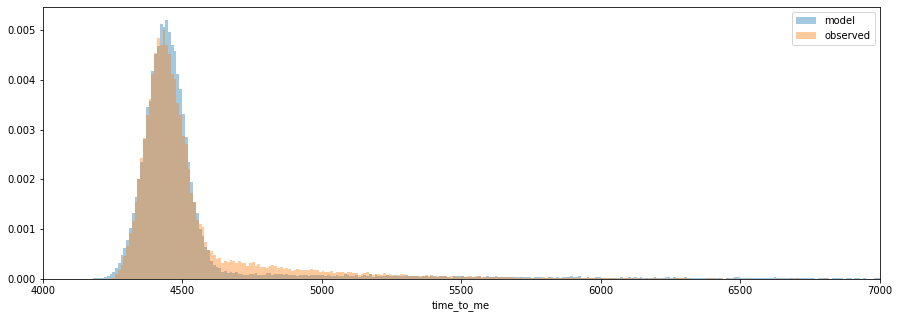

In [14]:
plt.figure(figsize=[15, 5])
sns.distplot(ppc_time_to_me, kde=False, norm_hist=True, bins=np.arange(0, 8000, 10), label='model')
sns.distplot(df.time_to_me, kde=False, norm_hist=True, bins=np.arange(0, 8000, 10), label= 'observed')
plt.xlim([4000, 7000])
plt.legend()